In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import sys


# Import classifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

# Import TQDM for plotting purposes
from tqdm.notebook import trange, tqdm

import torch

### Data Preparation

Let's first import all the datasets associated to the experimental curves in train and test sets. We will reshape these data as needed.

In [3]:
def fit_clf(X_train,y_train, X_test, y_test, clf, parameters):
    """Given raw data, generate a training and testing set and then GridSearch over the dataset to 
    identify the best possible combinations for a classifer. Train a model over this, and then return 
    the best accuracy and the best model. 
    """
    # Now grid search over teh data and fit the best possible hyperparameters. Note we are using a threefold
    # cross validation procedure. 
    model_tuning = GridSearchCV(clf, param_grid=parameters,cv = 3, scoring='accuracy', verbose=1, n_jobs = -1)
    model_tuning.fit(X_train, y_train);
    clf_best = model_tuning.best_estimator_
    
    # Refit our best hyperparameter setup onto our training data in its totality one last time and print out
    # the average score on the training data. We anticipate this to be a large accuracy. 
    clf_best.fit(X_train,y_train)
    train_score = clf_best.score(X_train,y_train)
    test_score = clf_best.score(X_test,y_test)
    
    return clf_best, train_score, test_score

In [4]:
# Define hyperparameters to search over
parameters = {
    "estimator__C": [0.01,0.1,1,10],
    "estimator__kernel": ["rbf","linear",],
    "estimator__gamma":[0.01,1,10]
}

Assess basic results on original dataset:

In [5]:
X_train_raw = np.load("./data/training_curves.npy")
X_test_raw = np.load("./data/testing_curves.npy")

# Prep data
ODs = X_train_raw[:,1,:]
GFPs = X_train_raw[:,2,:]

OD_max = ODs.max()
OD_min = ODs.min()
GFP_max = GFPs.max()
GFP_min = GFPs.min()

ODs = (ODs - ODs.min())/(ODs.max() - ODs.min())
GFPs = (GFPs - GFPs.min())/(GFPs.max() - GFPs.min())
X_train_reorg = np.hstack([ODs, GFPs])
X_train = torch.Tensor(X_train_reorg).cpu().numpy()#.unsqueeze(1)

ODs = X_test_raw[:,1,:]
GFPs = X_test_raw[:,2,:]

ODs = (ODs - OD_min)/(OD_max - OD_min)
GFPs = (GFPs - GFP_min)/(GFP_max - GFP_min)
X_test_reorg = np.hstack([ODs, GFPs])
X_test = torch.Tensor(X_test_reorg).cpu().numpy()

X_test.shape

(1200, 290)

## Run Classification

Next we run our classificaiton experiments on the system. First we compute the performance on the raw data without any VAE embedding: 

In [6]:
base_train_scores = []
base_test_scores = []
labels = ["plasmid", "strain", "inhibitor", "combo"]

for label in tqdm(labels): 
    y_train = np.load(f'./data/train_{label}_labels.npy')
    y_test = np.load(f'./data/test_{label}_labels.npy')
    
    
    clf = OneVsRestClassifier(SVC())
    clf, base_train_score, base_test_score = fit_clf(X_train, y_train, X_test, y_test, clf, parameters)
    
    base_train_scores.append(base_train_score)
    base_test_scores.append(base_test_score)
    
print("BASE TRAIN SCORE: ",base_train_scores )
print("BASE TEST SCORE: ",base_test_scores)

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
BASE TRAIN SCORE:  [0.6145833333333334, 0.9883333333333333, 0.8995833333333333, 0.9533333333333334]
BASE TEST SCORE:  [0.6225, 0.9808333333333333, 0.89, 0.9358333333333333]


Now we compute the same metrics but for the embeddings: 

In [28]:
file_path = './embeddings/convolutional_128_alpha_1e-4/'

train_scores = []
test_scores  = []

#em_dims = [10, 15,20,25,30,40]
em_dims = [3,5,10,20,30,50]



for label in tqdm(labels):
    
    label_train_scores = []
    label_test_scores = []
    
    y_train = np.load(f'./data/train_{label}_labels.npy')
    y_test = np.load(f'./data/test_{label}_labels.npy')
    
    for em_dim in tqdm(em_dims): 
        X_train = np.load(file_path + f"train_{em_dim}.npy")
        X_test =  np.load(file_path + f"test_{em_dim}.npy")
        
        
        data_scaler = MinMaxScaler()
        X_max = X_train.max()
        X_min = X_train.min()
        X_train = (X_train - X_min)/(X_max - X_min) #data_scaler.fit_transform(X_train)
        X_test = (X_test - X_min)/(X_max - X_min) #data_scaler.transform(X_test)
        
        clf = OneVsRestClassifier(SVC())
        clf, train_score, test_score = fit_clf(X_train, y_train, X_test, y_test, clf, parameters)
        
        label_train_scores.append(train_score)
        label_test_scores.append(test_score)
        
    train_scores.append(label_train_scores)
    test_scores.append(label_test_scores)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [29]:
def gen_plot(max_score, dimensions, embed_scores, title, ytitle, experiment_name, color = "r"):
    # Configure the plotting stlye
    plt.figure(figsize=(10,6))
   
    plt.ylim(0.0,1.05)
    plt.xlim(0,30)
    # Plot the data
    plt.plot([0, max(dimensions)+20],[max_score, max_score], "--",linewidth = 3, label = "Full Dimension Accuracy")
    plt.scatter(dimensions, embed_scores, c = color)
    plt.plot(dimensions, embed_scores, c = color, linewidth = 4)
    plt.legend(loc = "lower right")
    plt.xlabel("Embedding Dimension")
    plt.ylabel(ytitle)
    plt.title(title, pad = 10)

In [30]:
from scipy.optimize import curve_fit

def log_func(x, a, b):
    return a * np.log(b*x) 

def exp_func(x,a, b,c):
    return a*np.exp(-b*x)+c

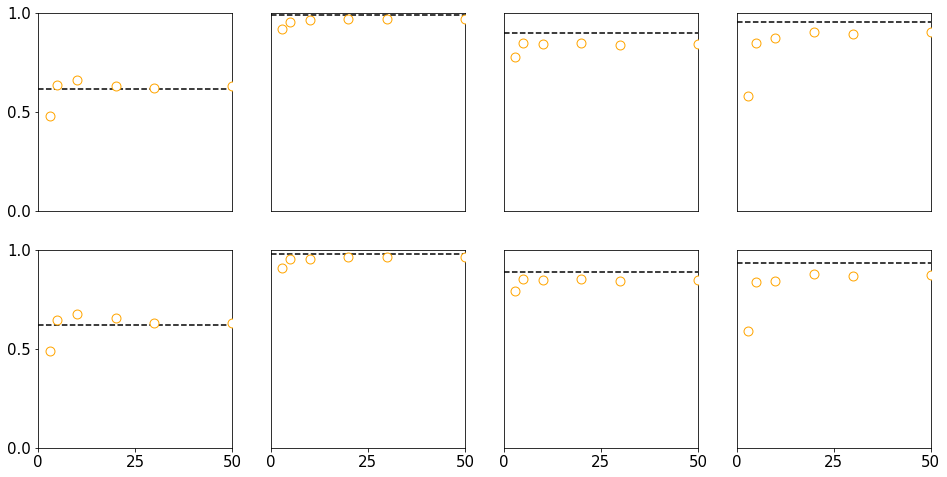

In [33]:
labels = ["plasmid", "strain", "inhibitor", "combo"]


fig, axs = plt.subplots(2, len(labels), figsize=(4*len(labels), 2*len(labels)), sharex=True, sharey=False)
axs = axs.flatten()

for i in range(len(labels) * 2):


    # Increase the font size of y-axis ticks
    #ax.tick_params(axis='y', labelsize=14)

    if i < len(labels):
        ax = axs[i]
        label = labels[i]
        base_train_score = base_train_scores[i]

        ax.axhline(base_train_score, color='black', linestyle='--')
        ax.scatter(em_dims, train_scores[i], s= 80, color='white', edgecolor='orange', zorder=3)
        #ax.plot(em_dims, train_scores[i], color='orange')
        ax.set_ylim(0, 1.0)
        ax.set_xticks([0, 25, 50])
        #ax.set_title(label, fontsize=20)
        ax.tick_params(bottom = False, labelsize = 15)
        ax.set_yticks([0,0.5, 1], size = 20)
        ax.minorticks_off()
        ax.set_xlim(0,50.0)
        
#         params, covarinace = curve_fit( log_func, em_dims, train_scores[i])
#         a, b = params
#         x = np.linspace(0.001,55,100)
#         ax.plot(x, a*np.log(b*x), color = 'orange', linewidth = 2, linestyle = 'solid', )

    
    else:
        ax = axs[i]
        base_test_score = base_test_scores[i - len(labels)]

        label = labels[i - len(labels)]
        ax.axhline(base_test_score, color='black', linestyle='--')
        ax.scatter(em_dims, test_scores[i - len(labels)], s= 80, color='white', edgecolor='orange', zorder=3)
        # ax.plot(em_dims, test_scores[i-len(labels)], color='red')
        ax.set_ylim(0, 1.0)
        ax.set_xticks([0, 25, 50])
        ax.tick_params(left = True, labelsize = 15)
        ax.set_yticks([0,0.5, 1], fontsize = 100)
        ax.set_xlim(0,50.0)
        
#         params, covarinace = curve_fit( log_func, em_dims, train_scores[i - len(labels)])
#         a,b = params
#         x = np.linspace(0.001,55,100)
#         ax.plot(x, a*np.log(b*x), color = 'orange', linewidth = 2, linestyle = 'solid', )
        


for i, ax in enumerate(axs):
    if i != 0 and i != 4:
        ax.set_yticks([])
        
plt.show()


In [ ]:
!pip install umap-learn

In [34]:
import umap

reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_train)

In [36]:
label = 'strain'
y_train = np.load(f'./data/train_{label}_labels.npy')
DA_labels = y_train[y_train == 0]
tenF_labels =y_train[y_train == 1]

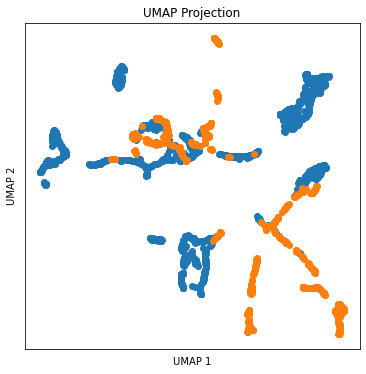

In [37]:

label = 'strain'
y_train = np.load(f'./data/train_{label}_labels.npy')

plt.figure(figsize = (6,6))
plt.xticks([])
plt.yticks([])
for i in np.unique(y_train):
    plt.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], )
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection')
plt.show()

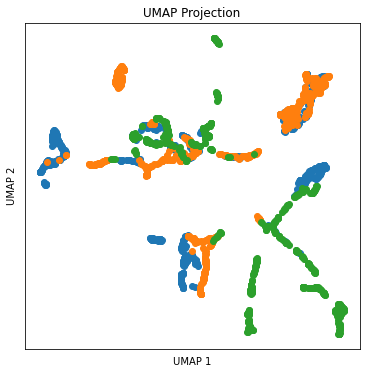

In [38]:
label = 'inhibitor'
y_train = np.load(f'./data/train_{label}_labels.npy')


plt.figure(figsize = (6,6))
plt.xticks([])
plt.yticks([])
for i in np.unique(y_train):
    plt.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], )
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection')
plt.show()

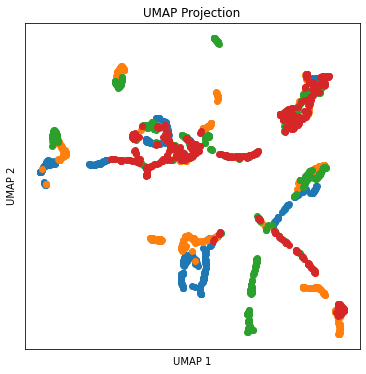

In [39]:
label = 'plasmid'
y_train = np.load(f'./data/train_{label}_labels.npy')


plt.figure(figsize = (6,6))
plt.xticks([])
plt.yticks([])
for i in np.unique(y_train):
    plt.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], )
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection')
plt.show()

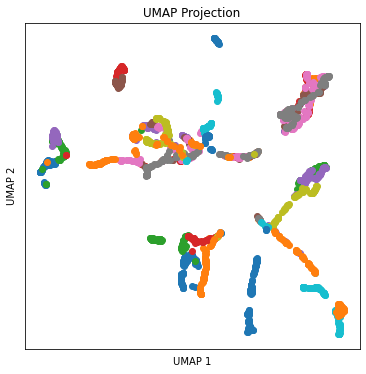

In [40]:
label = 'combo'
y_train = np.load(f'./data/train_{label}_labels.npy')


plt.figure(figsize = (6,6))
plt.xticks([])
plt.yticks([])
for i in np.unique(y_train):
    plt.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], )
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Projection')
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

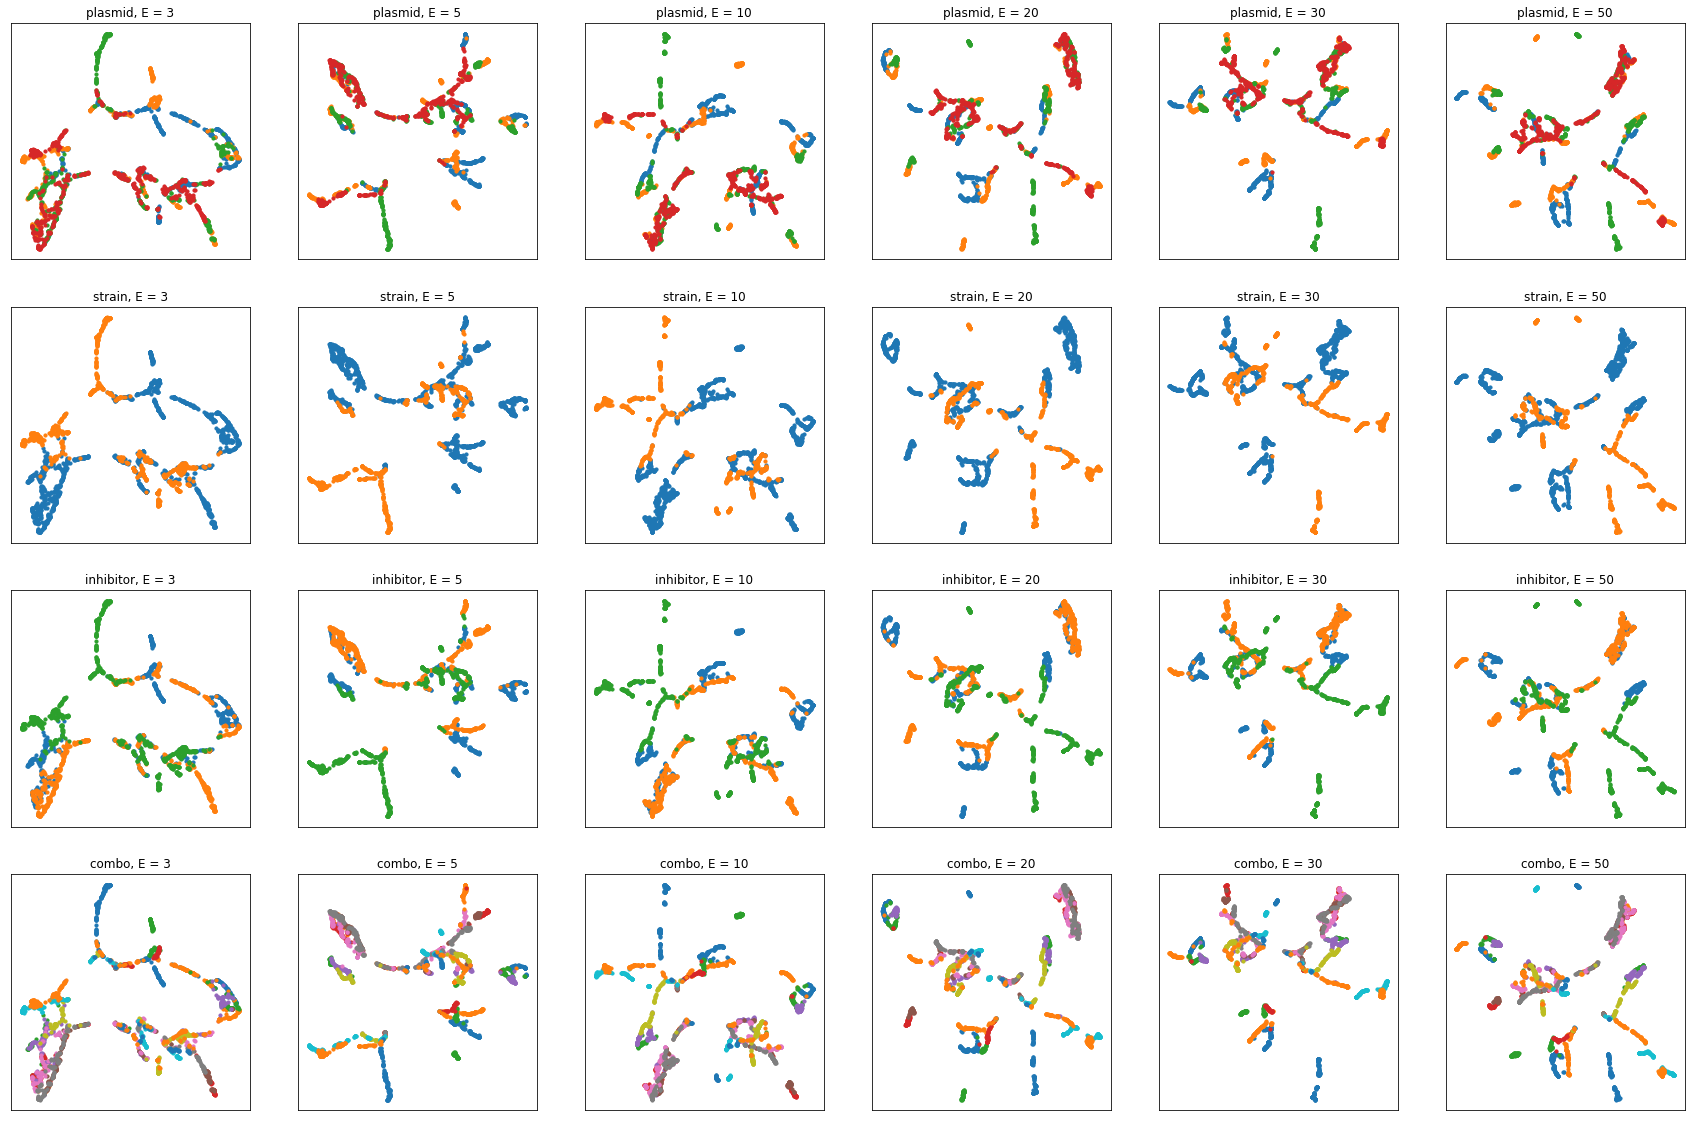

In [46]:
labels = ["plasmid", "strain", "inhibitor", "combo"]


fig, axs = plt.subplots( 4, len(em_dims) , figsize = ( 6/4*20, 20 ) )

for i in trange(len(em_dims)):
    reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_train)
    col = axs[:,i]
    em_dim = em_dims[i]
    # Pull off the embeddings
    X_train = np.load(file_path + f"train_{em_dim}.npy")
    X_test =  np.load(file_path + f"test_{em_dim}.npy")

    X_max = X_train.max()
    X_min = X_train.min()
    X_train = (X_train - X_min)/(X_max - X_min) #data_scaler.fit_transform(X_train)
    X_test = (X_test - X_min)/(X_max - X_min) #data_scaler.transform(X_test)
    
    # Project it down
    reducer = umap.UMAP()
    X_umap = reducer.fit_transform(X_train)


    
    # Now iterate over the labels
    for j, label in enumerate(labels):
        
        ax = col[j]
        
        # Plot them
        y_train = np.load(f'./data/train_{label}_labels.npy')
        
        for i in np.unique(y_train):
            ax.scatter(X_umap[y_train == i, 0], X_umap[y_train == i, 1], s = 10 )
            
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(f"{label}, E = {em_dim}")

In [42]:
labels

['plasmid', 'strain', 'inhibitor', 'combo']

In [43]:
labels = ['anti','inh_con']
y_train = np.load(f'./data/train_{labels[1]}_labels.npy')
np.unique(y_train).shape

(10,)

  0%|          | 0/6 [00:00<?, ?it/s]

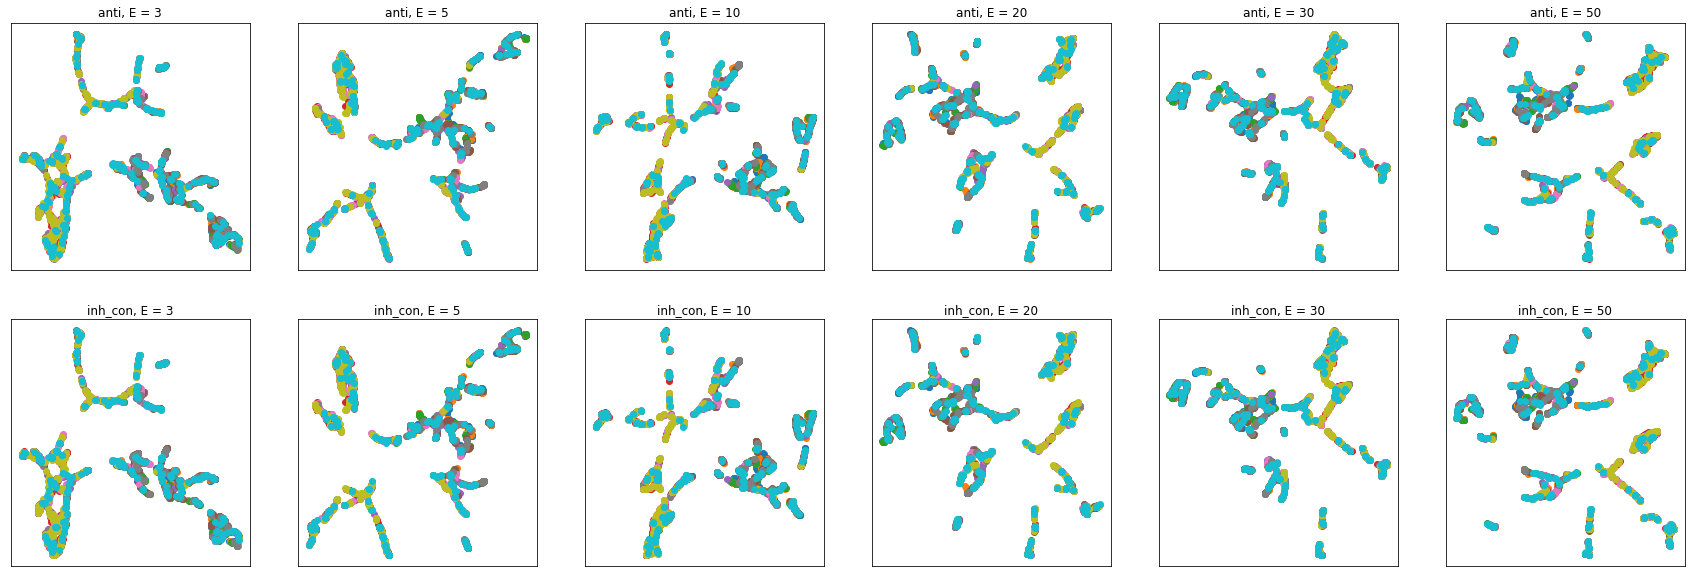

In [44]:
fig, axs = plt.subplots( 2, len(em_dims) , figsize = ( 120/4, 40/4 ) )
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

for i in trange(len(em_dims)):
    col = axs[:,i]
    em_dim = em_dims[i]
    # Pull off the embeddings
    X_train = np.load(file_path + f"train_{em_dim}.npy")
    X_test =  np.load(file_path + f"test_{em_dim}.npy")

    data_scaler = MinMaxScaler()
    X_max = X_train.max()
    X_min = X_train.min()
    X_train = (X_train - X_min)/(X_max - X_min) #data_scaler.fit_transform(X_train)
    X_test = (X_test - X_min)/(X_max - X_min) #data_scaler.transform(X_test)
    
    # Project it down
    X_umap = reducer.fit_transform(X_train)
    
    # Now iterate over the labels
    for j, label in enumerate(labels):
        
        ax = col[j]
        
        # Plot them
        
        
        for k,flag in enumerate(np.unique(y_train)):
            ax.scatter(X_umap[y_train == flag, 0], X_umap[y_train == flag, 1], color = colors[k])
            
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(f"{label}, E = {em_dim}")